## POS Tagging

**Part-of-speech** (POS) **tagging** is a popular Natural Language Processing process which refers to categorizing words in a text (corpus) in correspondence with a particular part of speech, depending on the definition of the word and its context. In this assignment  we will ask you to perform POS tagging using neural architectures:
*   Download the corpora and split it in training and test sets, structuring a dataframe.
*   Embed the words using GloVe embeddings
*   Create a baseline model, using a simple neural architecture
*   Experiment doing small modifications to the baseline model, choose hyperparameters using the validation set
*   Evaluate your two best model
*   Analyze the errors of your model

In [1]:
import numpy as np
CUSTOM_SEED = 42
np.random.seed(CUSTOM_SEED)

In [2]:
# Getting an annotated corpus
import nltk
nltk.download('treebank')
nltk.download('universal_tagset')

[nltk_data] Downloading package treebank to
[nltk_data]     /Users/linghuang/nltk_data...
[nltk_data]   Package treebank is already up-to-date!
[nltk_data] Downloading package universal_tagset to
[nltk_data]     /Users/linghuang/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


True

In [3]:
from nltk.corpus import treebank

sentences = treebank.tagged_sents(tagset='universal')

In [4]:
import random

print(random.choice(sentences))

[('Aerospace', 'NOUN'), ('earnings', 'NOUN'), ('sagged', 'VERB'), ('37', 'NUM'), ('%', 'NOUN'), ('for', 'ADP'), ('the', 'DET'), ('quarter', 'NOUN'), ('and', 'CONJ'), ('15', 'NUM'), ('%', 'NOUN'), ('for', 'ADP'), ('the', 'DET'), ('year', 'NOUN'), (',', '.'), ('largely', 'ADV'), ('due', 'ADJ'), ('to', 'PRT'), ('lower', 'ADJ'), ('B-1B', 'NOUN'), ('program', 'NOUN'), ('profit', 'NOUN'), (';', '.'), ('the', 'DET'), ('last', 'ADJ'), ('of', 'ADP'), ('the', 'DET'), ('bombers', 'NOUN'), ('rolled', 'VERB'), ('out', 'ADP'), ('in', 'ADP'), ('April', 'NOUN'), ('1988', 'NUM'), ('.', '.')]


In [5]:
tags = set([
    tag for sentence in treebank.tagged_sents()
    for _, tag in sentence
])
print('nb_tags: %sntags: %s' % (len(tags), tags))

nb_tags: 46ntags: {'VBN', 'IN', 'WP$', 'VBG', 'CC', '``', 'VBZ', '-LRB-', 'UH', 'JJS', 'VB', 'FW', 'VBD', 'WDT', 'EX', ':', 'RBS', 'SYM', 'MD', 'WRB', "''", 'NNPS', 'NN', 'CD', 'NNP', '-NONE-', '#', 'JJR', '.', 'RBR', 'VBP', 'DT', 'WP', 'PRP$', 'POS', ',', 'PDT', '$', '-RRB-', 'RB', 'LS', 'NNS', 'RP', 'JJ', 'PRP', 'TO'}


In [6]:
train_test_cutoff = int(.80 * len(sentences))
training_sentences = sentences[:train_test_cutoff]
testing_sentences = sentences[train_test_cutoff:]

train_val_cutoff = int(.25 * len(training_sentences))
validation_sentences = training_sentences[:train_val_cutoff]
training_sentences = training_sentences[train_val_cutoff:]

In [11]:
def add_basic_features(sentence_terms, index):
    """ Compute some very basic word features.
        :param sentence_terms: [w1, w2, ...]
        :type sentence_terms: list
        :param index: the index of the word
        :type index: int
        :return: dict containing features
        :rtype: dict
    """
    term = sentence_terms[index]
    return {
        'nb_terms': len(sentence_terms),
        'term': term,
        'is_first': index == 0,
        'is_last': index == len(sentence_terms) - 1,
        'is_capitalized': term[0].upper() == term[0],
        'is_all_caps': term.upper() == term,
        'is_all_lower': term.lower() == term,
        'prefix-1': term[0],
        'prefix-2': term[:2],
        'prefix-3': term[:3],
        'suffix-1': term[-1],
        'suffix-2': term[-2:],
        'suffix-3': term[-3:],
        'prev_word': '' if index == 0 else sentence_terms[index - 1],
        'next_word': '' if index == len(sentence_terms) - 1 else sentence_terms[index + 1]
    }

In [12]:
def untag(tagged_sentence):
    """
    Remove the tag for each tagged term.
:param tagged_sentence: a POS tagged sentence
    :type tagged_sentence: list
    :return: a list of tags
    :rtype: list of strings
    """
    return [w for w, _ in tagged_sentence]

def transform_to_dataset(tagged_sentences):
    """
    Split tagged sentences to X and y datasets and append some basic features.
:param tagged_sentences: a list of POS tagged sentences
    :param tagged_sentences: list of list of tuples (term_i, tag_i)
    :return:
    """
    X, y = [], []
    for pos_tags in tagged_sentences:
        for index, (term, class_) in enumerate(pos_tags):
            # Add basic NLP features for each sentence term
            X.append(add_basic_features(untag(pos_tags), index))
            y.append(class_)
    return X, y # Fixed indentation here

In [13]:
X_train, y_train = transform_to_dataset(training_sentences)
X_test, y_test = transform_to_dataset(testing_sentences)
X_val, y_val = transform_to_dataset(validation_sentences)

In [14]:
from sklearn.feature_extraction import DictVectorizer

# Fit our DictVectorizer with our set of features
dict_vectorizer = DictVectorizer(sparse=False)
dict_vectorizer.fit(X_train + X_test + X_val)

# Convert dict features to vectors
X_train = dict_vectorizer.transform(X_train)
X_test = dict_vectorizer.transform(X_test)
X_val = dict_vectorizer.transform(X_val)

In [15]:
from sklearn.preprocessing import LabelEncoder

# Fit LabelEncoder with our list of classes
label_encoder = LabelEncoder()
label_encoder.fit(y_train + y_test + y_val)

# Encode class values as integers
y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)
y_val = label_encoder.transform(y_val)

In [16]:
# Convert integers to dummy variables (one hot encoded)
from tensorflow.keras.utils import to_categorical  # Import to_categorical directly
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

In [17]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation

def build_model(input_dim, hidden_neurons, output_dim):
    """
    Construct, compile and return a Keras model which will be used to fit/predict
    """
    model = Sequential([
        Dense(hidden_neurons, input_dim=input_dim),
        Activation('relu'),
        Dropout(0.2),
        Dense(hidden_neurons),
        Activation('relu'),
        Dropout(0.2),
        Dense(output_dim, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model # Dedent this line to align with the function definition

In [18]:
!pip install scikeras  # Install the scikeras package to use KerasClassifier

In [19]:
from scikeras.wrappers import KerasClassifier  # Import KerasClassifier from scikeras

model_params = {
    'build_fn': build_model,
    'input_dim': X_train.shape[1],
    'hidden_neurons': 512,
    'output_dim': y_train.shape[1],
    'epochs': 5,
    'batch_size': 256,
    'verbose': 1,
    'shuffle': True # Removed validation_data from model_params
}
clf = KerasClassifier(**model_params)

In [ ]:
# Passvalidation data directly to the fit method
hist = clf.fit(X_train, y_train, validation_data=(X_val, y_val)) # Pass validation_data to fit

In [ ]:
import matplotlib.pyplot as plt

def plot_model_performance(train_loss, train_acc, train_val_loss, train_val_acc):
    """ Plot model loss and accuracy through epochs. """
    blue= '#34495E'
    green = '#2ECC71'
    orange = '#E23B13'
    # plot model loss
    fig, (ax1, ax2) = plt.subplots(2, figsize=(10, 8))
    ax1.plot(range(1, len(train_loss) + 1), train_loss, blue, linewidth=5, label='training')
    ax1.plot(range(1, len(train_val_loss) + 1), train_val_loss, green, linewidth=5, label='validation')
    ax1.set_xlabel('# epoch')
    ax1.set_ylabel('loss')
    ax1.tick_params('y')
    ax1.legend(loc='upper right', shadow=False)
    ax1.set_title('Model loss through #epochs', color=orange, fontweight='bold')
    # plot model accuracy
    ax2.plot(range(1, len(train_acc) + 1), train_acc, blue, linewidth=5, label='training')
    ax2.plot(range(1, len(train_val_acc) + 1), train_val_acc, green, linewidth=5, label='validation')
    ax2.set_xlabel('# epoch')
    ax2.set_ylabel('accuracy')
    ax2.tick_params('y')
    ax2.legend(loc='lower right', shadow=False)
    ax2.set_title('Model accuracy through #epochs', color=orange, fontweight='bold')

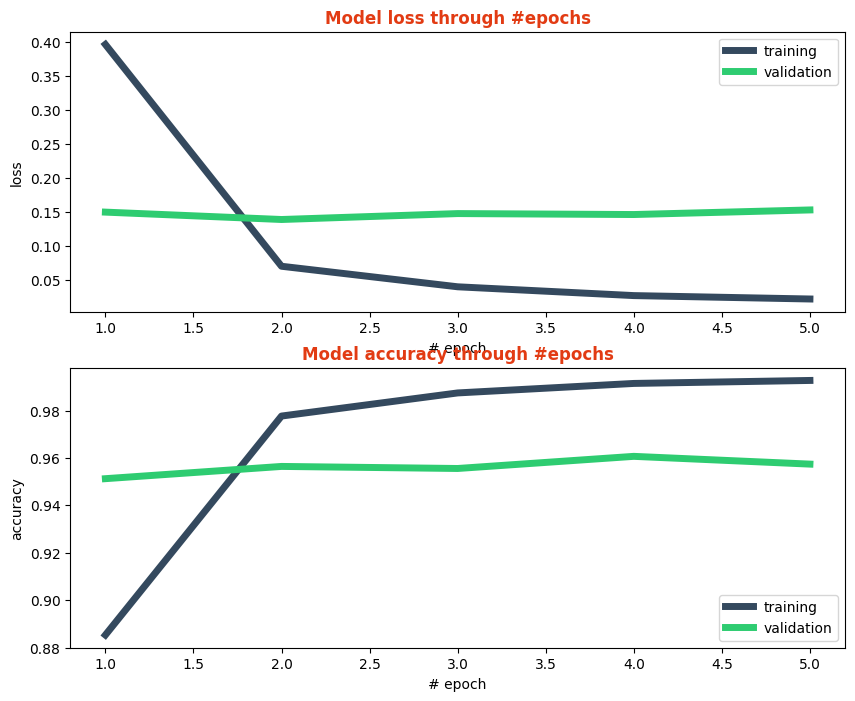

In [ ]:
model = clf.model_ # Get the underlying Keras model
plot_model_performance(
    train_loss=model.history.history.get('loss', []), # Access history from the model
    train_acc=model.history.history.get('accuracy', []), # Note: 'accuracy' instead of 'acc'
    train_val_loss=model.history.history.get('val_loss', []),
    train_val_acc=model.history.history.get('val_accuracy', []) # Note: 'val_accuracy' instead of 'val_acc'
)

In [ ]:
score = clf.score(X_test, y_test)
print(score)

79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
0.9656170467588203


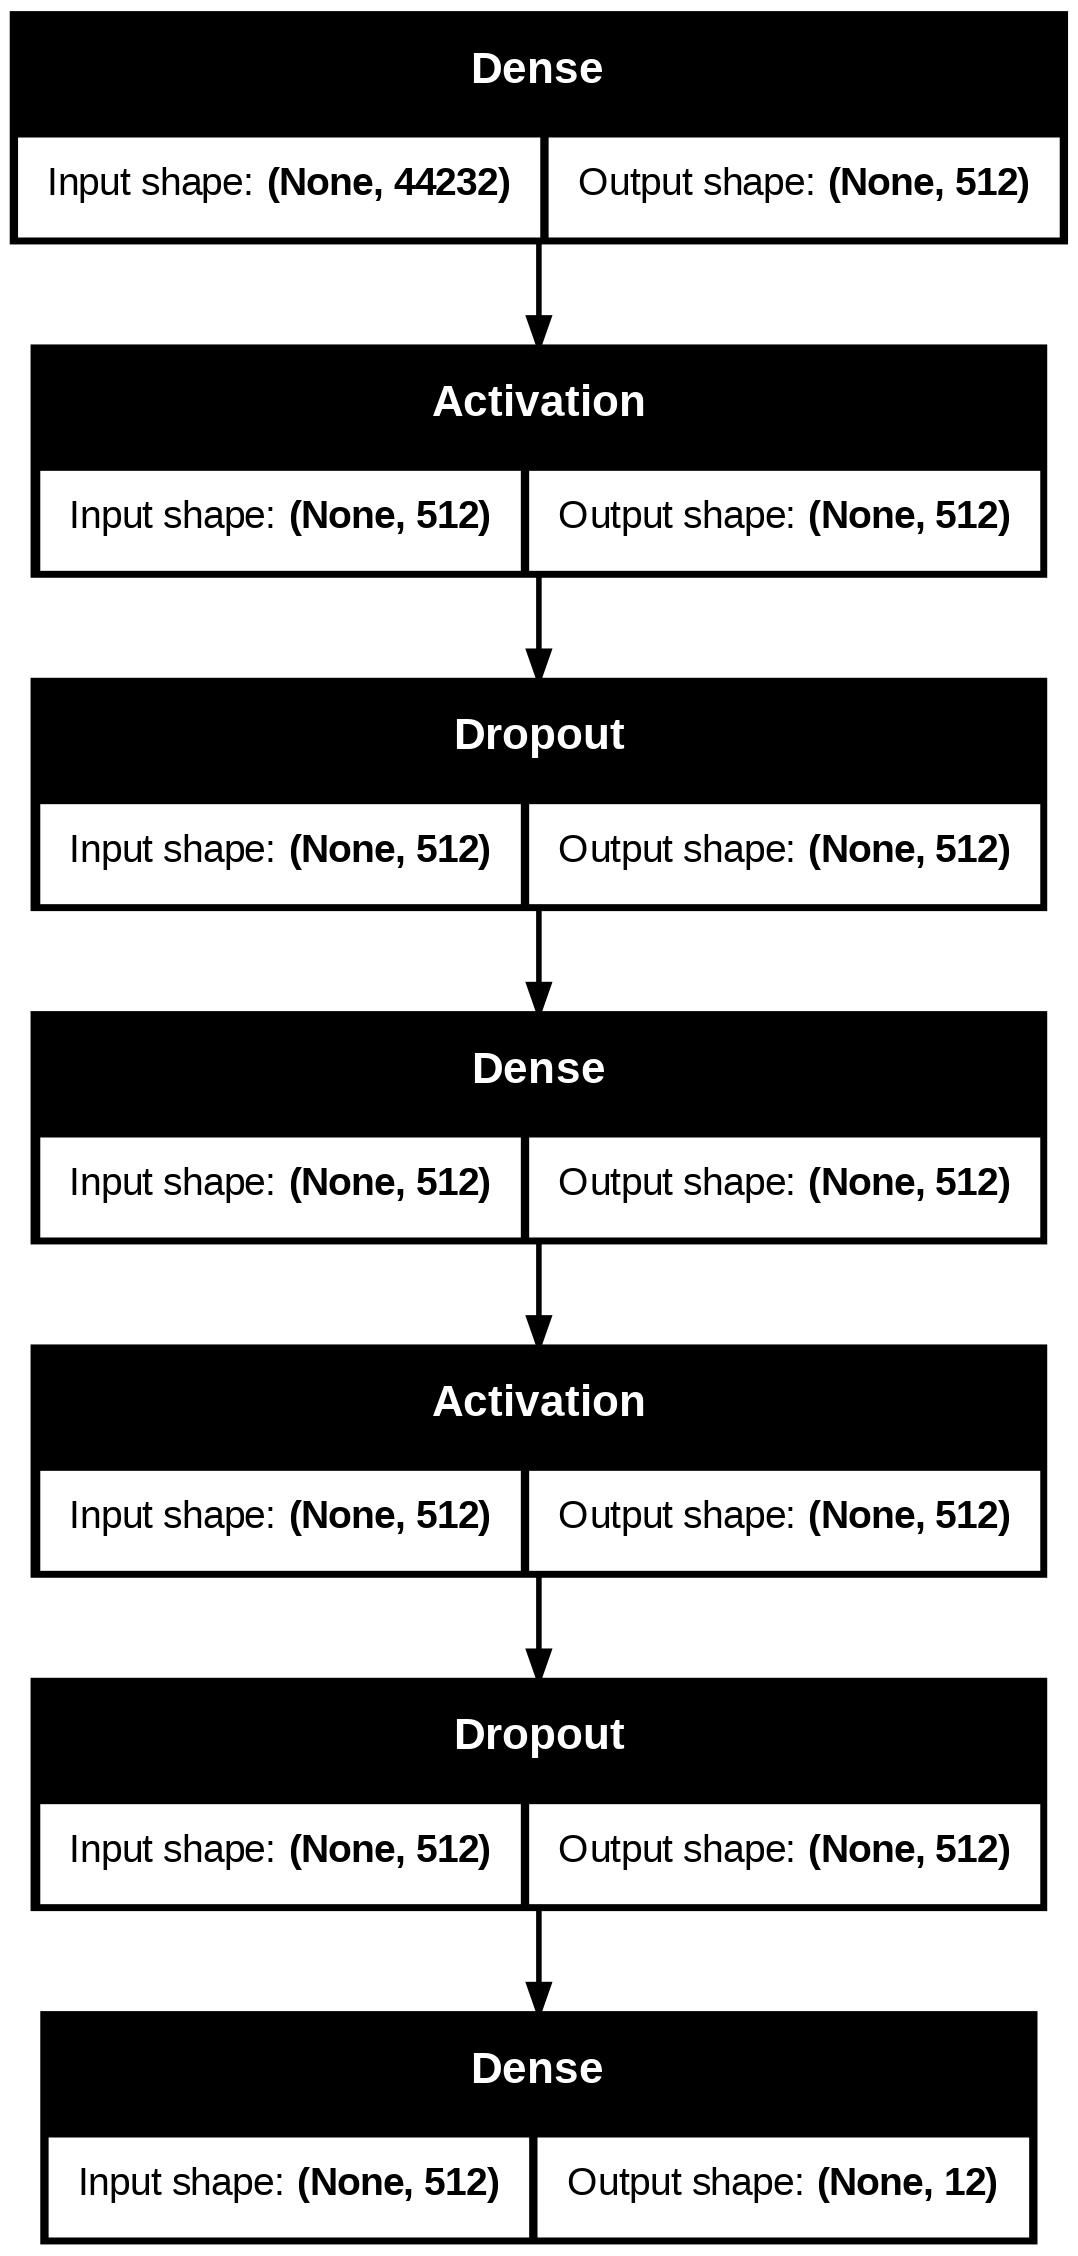

In [ ]:
from keras.utils import plot_model

plot_model(clf.model_, to_file='model.png', show_shapes=True) # Note: use clf.model_ to access the underlying Keras model

In [27]:
clf.model_.save('/tmp/keras_mlp.h5') # Use clf.model_ to access the trained Keras model